In [1]:
# Autoreload modules
%load_ext autoreload
%autoreload 2


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
import numpy as np

import os
import re
import glob
import json
from mldec.models import tune_model


#### Hyperparameter tuning

april 4 - First round hyperparameters to remove:
 - learning rates undershot pretty badly. Remove 1.e-05, 5e-05, 1e-04, 5e-4
 - among these, gcn_depth=3 is very bad, gcn_min=16 is bad, mlp_max=32 is bad


 april 11 - Second round of hyperparameters
 - lr=0.002 is quite good compared to everything else. remove .001, .003, .004, .005
 - gcn_depth=7 very bad, gcn_depth=6 pretty bad also but worth keeping probably. However, this might be due to lack of training data.
 - mlp_depth and max don't matter, but mlp_max=256
 - all else is fine.

(potential) issues: 
 - The batch sizes were pretty small, and now i need to ramp up total training data. So I'm going to increase batch size significantly, and therefore allow for smaller lrs. 
 - A lot of training was done over a relatively small number of epochs (300) for 100000 (1e5) training data. Compare this to maybe 50-100 epochs for >1e7 data in Lange's work. With variable training data, I'll keep patience at 300 epochs, that should be more than sufficient.

```
v0.2 hypers:
  lr: [0.0001, 0.0002, 0.0003]
  batch_size: [512, 1024]
  gcn_depth: [5, 6, 7]
  gcn_min: [32, 64]
  mlp_depth: [3, 4]
  mlp_max: [128, 256]
  n_train: [131072, 262144, 524288, 1048576]

knob_settings:
  beta: [1, 2]

```

```
v1.0 hypers:
  lr: [ 0.0002, 0.0003, 0.0004]
  batch_size: [512, 1024]
  gcn_depth: [4, 5, 6]
  gcn_min: [32, 64]
  mlp_depth: [3, 4]
  mlp_max: [128]
  n_train: [131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608]

knob_settings:
  beta: [1, 2, 3]
```


#### Load unfinished runs

The below code is specifically for experiments from April 24, as unfinished runs. Many of these died, presumably due to problems with memory, not sure though.

In [3]:
def scrape_and_save_hypers_from_unfinished_run(dir, njobs):
    """
    Scrape hyperparameters from unfinished runs by looking at log.txt files.
    
    Args:
        dir: Directory containing zjob_i subdirectories
        
    Returns:
        Dictionary of hyperparameters
    """
    import os
    import re
    
    # Initialize empty dictionary to store hyperparameters
    hyper_dict = {}
    
    # Loop through job directories from 0 to 49
    for i in range(njobs):
        # Skip if hyper_config.json already exists
        hyper_config_path = os.path.join(dir, f"zjob_{i}", "hyper_config.json")
        if os.path.exists(hyper_config_path):
            continue
                        
        # Reset hyper_dict for each job
        hyper_dict = {}
        log_path = os.path.join(dir, f"zjob_{i}", "log.txt")
        
        # Check if log file exists
        if not os.path.exists(log_path):
            continue
        
        # Read the log file
        with open(log_path, "r") as f:
            log_content = f.readlines()
        
        # Look at lines 19-26 (0-indexed)
        if len(log_content) >= 26:
            relevant_lines = log_content[18:27]  # Lines 19-26 inclusive
            
            # Extract hyperparameters using regex
            for line in relevant_lines:
                # Look for patterns like "lr: 0.0004" or "batch_size: 512"
                match = re.search(r'(\w+):\s*([\d\.]+)', line)
                if match:
                    key, value = match.groups()
                    # Convert value to appropriate type (float or int)
                    if '.' in value:
                        hyper_dict[key] = float(value)
                    else:
                        hyper_dict[key] = int(value)
        # Save the extracted hyperparameters to a JSON file in the same zjob directory
        if hyper_dict:
            output_path = os.path.join(dir, f"zjob_{i}", "scraped_hyper_config.json")
            with open(output_path, "w") as f:
                json.dump(hyper_dict, f, indent=2)


    

In [16]:
def calculate_total_epochs(csv_path):
    # Read the CSV file
    df_epochs = pd.read_csv(csv_path)
    # Calculate total epochs (rows * 10)
    total_epochs = len(df_epochs) * 10
    return total_epochs

def recover_dataframce(dir, new_results=True, use_scraped_hypers=False):
    job_dirs = glob.glob(os.path.join(dir, "zjob_*"))
    
    n_jobs = len(job_dirs)
    data = []
    header_keys = tune_model.get_header().split(",")
    targets = []
    for i in range(n_jobs):
        if new_results:
            fname = f"./{dir}/zjob_{str(i)}/new_tune_results.csv"
        else:
            fname = f"./{dir}/zjob_{str(i)}/tune_results.csv"
        hyper_path = f"./{dir}/zjob_{str(i)}/hyper_config.json"
        # load the hyper config

        if not os.path.exists(hyper_path):
            # we want to default to using the original hyper config
            if use_scraped_hypers:
                hyper_path = f"./{dir}/zjob_{str(i)}/scraped_hyper_config.json"
            else:
                continue
        targets.append((fname, hyper_path, i))
    # print("Found the following files to clean up:")
    # print("\n".join([x[0] for x in targets]))
    for i, (fname, hyper_path, i) in enumerate(targets):
        with open(hyper_path, "r") as f:
            hyper_config = json.load(f)
        hyper_keys = list(hyper_config.keys())
        columns = header_keys + hyper_keys
        # load the results into pandas 
        df = pd.read_csv(fname)
        if len(df) == 0:
            continue
        best_row = df[df['val_acc'] == df['val_acc'].max()]
        best_row = best_row[best_row['epoch'] == best_row['epoch'].min()]
        # get a list of values "[epoch,train_loss,train_acc,val_acc,noiseless_val_acc]"
        best_result = best_row.values[0]
        # get the hyperparameters
        hyper_setting = [hyper_config.get(k) for k in hyper_keys]
        x = list(best_result) + list(hyper_setting)
        data.append(x)
    
    if len(targets) == 0:
        raise ValueError(f"No targets found in directory {dir}")

    recovered_df = pd.DataFrame(data, columns=columns)
    return recovered_df

def load_dataframe_with_metadata(df, dir, new_results=True, use_scraped_hypers=False):
    """After a run is finished, we can scrape metadata to augment our dataframe.
    
    This is specifically for reps-toric-code-exp-v1.0?-unfinished
    """
    # Initialize lists to store data
    job_ids = []
    param_counts = []
    time_elapsed = []
    total_epochs_lst = []
    betas = []
    # Get the finished run results
    # df = pd.read_csv(os.path.join(dir, "gnn_reps_toric_code_results.csv"))
    # Find all zjob directories
    job_dirs = glob.glob(os.path.join(dir, "zjob_*"))
    for job_dir in job_dirs:
        log_path = os.path.join(job_dir, "log.txt")
        # use hyper json to check whether we skip this dir.
        hyper_config_path = os.path.join(job_dir, "hyper_config.json")
        if not os.path.exists(hyper_config_path):
            if use_scraped_hypers:
                hyper_config_path = os.path.join(job_dir, "scraped_hyper_config.json")
            else:
                continue

        if new_results:
            csv_file = os.path.join(job_dir, "new_tune_results.csv")
        else:
            csv_file = os.path.join(job_dir, "tune_results.csv")
        total_epochs = calculate_total_epochs(csv_file)
        total_epochs_lst.append(total_epochs)

        assert os.path.exists(log_path)
        with open(log_path, 'r') as f:
            log_content = f.read()
            lines = log_content.strip().split('\n')

            # Extract job ID from directory name
            job_id = os.path.basename(job_dir).replace("zjob_", "")
            
            # Extract parameter count
            param_match = re.search(r"Training model gnn with (\d+) total parameters", log_content)
            param_count = int(param_match.group(1)) if param_match else None
            
            # n_train = re.search(r"n_train: (\d+)", log_content)
            # n_train = int(n_train.group(1)) if n_train else None

            beta = re.search(r"beta: (\d+)", lines[35])     
            beta = int(beta.group(1)) if beta else None
            betas.append(beta)
            # Extract time elapsed from second-to-last line
            if len(lines) >= 2:
                time_match = re.search(r"Epoch \d+/\d+ \| Time elapsed: ([\d\.]+)", lines[-2])
                elapsed = float(time_match.group(1)) if time_match else None
            else:
                elapsed = None
            
            # Append data if found
            if param_count is not None or elapsed is not None:
                job_ids.append(job_id)
                param_counts.append(param_count)
                time_elapsed.append(elapsed)

    # Create a DataFrame with the extracted data
    params_df = pd.DataFrame({
        'job_id': job_ids,
        'param_count': param_counts,
        'time_elapsed': time_elapsed,
        'total_epochs': total_epochs_lst,
        "beta": betas
    })
    # Convert job_id to string in both dataframes to ensure proper matching

    params_df['job_id'] = params_df['job_id'].astype(str)
    df['job_id'] = df['job_id'].astype(int).astype(str)
    df = pd.merge(df, params_df, on='job_id', how='outer')
    
    return df

In [17]:
from mldec.codes import reps_toric_code
DONE = True
if not DONE:
    # compute the very-accurate MWPM(beta=1) error rates for beta=1,2,3
    # takes about 5-10 minutes
    mpwm_ranges = []
    for _ in range(1):
        mwpm_err_beta1 = reps_toric_code.estimate_mwpm_error({'p': 0.001,'repetitions': 5,'code_size': 3, 'beta': 1}, 1e8)
        mwpm_err_beta2 = reps_toric_code.estimate_mwpm_error({'p': 0.001,'repetitions': 5,'code_size': 3, 'beta': 2}, 1e8)
        mwpm_err_beta3 = reps_toric_code.estimate_mwpm_error({'p': 0.001,'repetitions': 5,'code_size': 3, 'beta': 3}, 1e8)
        mwpm_errs = [mwpm_err_beta1, mwpm_err_beta2, mwpm_err_beta3]
        print(mwpm_errs)

    # Create a DataFrame with the MWPM error rates
    mwpm_df = pd.DataFrame({
        'beta': [1, 2, 3],
        'mwpm_error': mwpm_errs
    })

    # Save to file
    mwpm_df.to_csv('mwpm-toric-code/10e8_mwpm_errors_betas123.csv', index=False)
else:
    # Load the MWPM error rates from the saved CSV file
    mwpm_df = pd.read_csv('mwpm-toric-code/10e8_mwpm_errors_betas123.csv')
    mwpm_errs = mwpm_df['mwpm_error'].tolist()


##### Initial data and model size sweep

Try to find a general pattern between training set size and runtime

Analysis note: For $\beta=3$ with $8\times 10^6$ training data, I think we hit a memory limit that kills a lot of processes sporadically. This means that a lot of jobs didn't finish, but nonetheless these $\beta=3$ jobs all did well so the ones that I keep are necessarily _underreporting_ the performance of $\beta=3$ and so this cannot constitute cherry-picking. For this reason, I am allowing these data to stay. One exception is a single run that only lasted 10 epochs, which obviously isn't valid for reporting.

In [18]:
# get the data from the N sweep
# recovered_df_v02 = recover_dataframce("reps-toric-code-exp-v0.2")
# df_v02 = load_dataframe_with_metadata(recovered_df_v02, "reps-toric-code-exp-v0.2")

epoch_cutoff = 200

dir_a = "reps-toric-code-exp-v1.0a"
recovered_df_a = recover_dataframce(dir_a)
df_a = load_dataframe_with_metadata(recovered_df_a, dir_a)
dir_b = "reps-toric-code-exp-v1.0b"
recovered_df_b = recover_dataframce(dir_b)
df_b = load_dataframe_with_metadata(recovered_df_b, dir_b)
# After the first two runs, i fixed the file writing bug, so we can use the 
# original recorded data by setting new_results=False
dir_c = "reps-toric-code-exp-v1.0c"
scrape_and_save_hypers_from_unfinished_run(dir_c, njobs=50)
recovered_df_c = recover_dataframce(dir_c, new_results=False, use_scraped_hypers=True)
df_c = load_dataframe_with_metadata(recovered_df_c, dir_c, new_results=False, use_scraped_hypers=True)
df_c = df_c[df_c["total_epochs"] >= epoch_cutoff]
dir_d = "reps-toric-code-exp-v1.0d"
scrape_and_save_hypers_from_unfinished_run(dir_d, njobs=50)
recovered_df_d = recover_dataframce(dir_d, new_results=False, use_scraped_hypers=True)
df_d = load_dataframe_with_metadata(recovered_df_d, dir_d, new_results=False, use_scraped_hypers=True)
df_d = df_d[df_d["total_epochs"] >= epoch_cutoff]

df_v03 = pd.concat([df_a, df_b, df_c, df_d])
target_df = df_v03
tot_wallclock = 0
tot = 0
for beta in [1, 2, 3]:
    print("beta=", beta)
    for jj, n_train in enumerate(sorted(target_df['n_train'].unique())):
        tot += len(target_df[(target_df['beta'] == beta) & (target_df['n_train'] == n_train)])
        base_wallclock = (jj + 1) * 2
        print("\t", n_train, len(target_df[(target_df['beta'] == beta) & (target_df['n_train'] == n_train)]))
print(tot)

beta= 1
	 131072 13
	 262144 11
	 524288 11
	 1048576 17
	 2097152 15
	 4194304 12
	 8388608 10
beta= 2
	 131072 12
	 262144 9
	 524288 14
	 1048576 30
	 2097152 32
	 4194304 19
	 8388608 11
beta= 3
	 131072 10
	 262144 23
	 524288 14
	 1048576 21
	 2097152 19
	 4194304 15
	 8388608 5
323


In [19]:
# get the datas from the N~10e6 run, beta sweep
# don't forget to re-download the results when running this.
timestamps = ["089930", "191024", "421538", "701131", "878453", "498068"]
njobs = 75
dfs = []
for timestamp in timestamps:
    dir = f"reps-toric-code-exp-v1.1-{timestamp}"
    scrape_and_save_hypers_from_unfinished_run(dir, njobs=njobs)
    recovered_df = recover_dataframce(dir, new_results=False, use_scraped_hypers=True)
    df = load_dataframe_with_metadata(recovered_df, dir, new_results=False, use_scraped_hypers=True)
    df = df[df["total_epochs"] >= epoch_cutoff]
    dfs.append(df)
    print(f"timestamp {timestamp}: gathered {len(df)} runs with >= {epoch_cutoff} epochs complete")
# add in the beta=1,2,3 data
dfs.append(df_v03[df_v03["n_train"] == 1048576])



timestamp 089930: gathered 66 runs with >= 200 epochs complete
timestamp 191024: gathered 68 runs with >= 200 epochs complete
timestamp 421538: gathered 74 runs with >= 200 epochs complete
timestamp 701131: gathered 59 runs with >= 200 epochs complete
timestamp 878453: gathered 75 runs with >= 200 epochs complete
timestamp 498068: gathered 25 runs with >= 200 epochs complete


In [20]:
# process the beta sweeep dataframes with real data
df_all = pd.concat(dfs, ignore_index=True)
medians = []
iqs = []
raw_vals = []
betasweep_betas = sorted(df_all["beta"].unique())
for beta in betasweep_betas:
    df_beta = df_all[df_all["beta"] == beta]
    raw_vals.append(1 - df_beta["val_acc"])
    # compute the median and iqr of val_acc
    median_val_err = 1 - df_beta["val_acc"].median()
    lb = 1 - df_beta["val_acc"].quantile(0.75)
    ub = 1 - df_beta["val_acc"].quantile(0.25)
    medians.append(median_val_err)
    iqs.append((lb, ub))


In [21]:
# Get the MWPM on beta vs beta=1 data computed on the cluster
df = pd.read_csv("mwpm-toric-code/mwpm_beta_val_beta1_benchmark_results_v1.csv")
mwpm_raw = []
mwpm_medians = []
mwpm_iqr = []
mwpm_betas = sorted(df["beta"].unique())
for beta in mwpm_betas:
    df_beta = df[df["beta"] == beta]
    temp = []
    for seed in df_beta["seed"].unique():
        df_seed = df_beta[df_beta["seed"] == seed]
        temp.append(1 - df_seed["accuracy"])
    mwpm_raw.append(temp)
    # compute the median accuracy
    median_err = 1 - df_beta["accuracy"].median()
    mwpm_medians.append(median_err)
    # compute the IQ range
    lb = 1 - df_beta["accuracy"].quantile(0.75)
    ub = 1 - df_beta["accuracy"].quantile(0.25)
    mwpm_iqr.append((lb, ub))

PLOT_MWPM = False
if PLOT_MWPM:
    fig, ax = plt.subplots()
    ax.plot(mwpm_betas, mwpm_medians)
    ax.fill_between(mwpm_betas, [x[0] for x in mwpm_iqr], [x[1] for x in mwpm_iqr], alpha=0.2)

    # plot the raw data
    for i in range(len(mwpm_betas)):
        beta = mwpm_betas[i]
        ax.scatter(beta * np.ones_like(mwpm_raw[i]), mwpm_raw[i], c='r', s=10, alpha=0.5)

    # ax.legend()
    ax.set_xlabel("factor increase for error rate in detector error model")

    # ax.set_ylabel("validation accuracy")
    plt.show()

In [22]:
def make_yvals_v1(df, n_train_vals, beta, target_col='val_acc'):
    """For each of n_train in n_train_vals, 
        get the val acc for all df['beta']==beta, compute its median and IQ range, 
        and append a tuple of that to the output."""
    output = []
    subset = df[df['beta'] == beta]
    
    for n_train in n_train_vals:
        # Filter for the specific n_train value
        n_train_subset = subset[subset['n_train'] == n_train]
        
        if len(n_train_subset) > 0:
            # Calculate median and IQR for validation accuracy
            n_train_subset['err'] = 1 - n_train_subset[target_col]
            median_val_err = n_train_subset['err'].median()
            y_lb = n_train_subset['err'].quantile(0.25)
            y_ub = n_train_subset['err'].quantile(0.75)
            
            # Append tuple of (n_train, median_val_acc, iqr)
            output.append((median_val_err, median_val_err - y_lb, y_ub - median_val_err))
        else:
            output.append((0, 0, 0))
    
    return np.array(output)


def make_yvals_v2(df, n_train_vals, beta, target_col='val_acc'):
    """For each of n_train in n_train_vals, 
        get the val acc for all df['beta']==beta, compute its median and IQ range, 
        and append a tuple of that to the output."""
    output = []
    subset = df[df['beta'] == beta]
    for n_train in n_train_vals:
        # Filter for the specific n_train value
        n_train_subset = subset[subset['n_train'] == n_train]
        output.append((np.array([n_train] * len(n_train_subset)), 1 - n_train_subset[target_col].values))
    return output


# prettier sci not
class CustomFormatter(ScalarFormatter):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.set_scientific(True)
        self.set_powerlimits((-1, 1))
    
    def _set_format(self, *args, **kwargs):
        super()._set_format(*args, **kwargs)
        self.format = '%.1f'  # Force one digit of precision

Text(0, 0.5, '')
Text(0, 0.5, '')
Text(0, 0.5, '')
[0.0001 0.001  0.01   0.1   ]


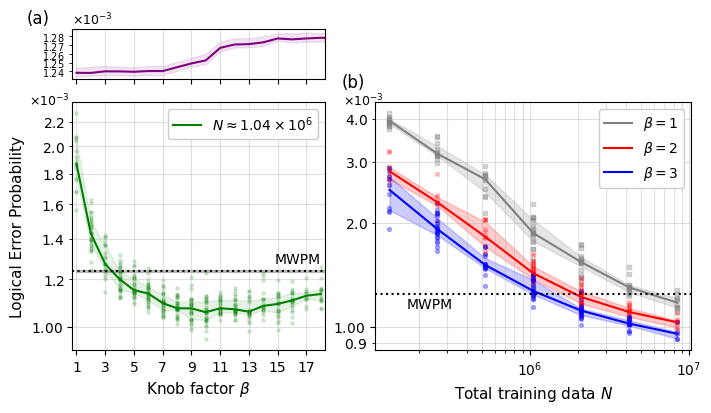

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=2, 
                         gridspec_kw={'height_ratios': [1, 5], 'width_ratios': [4, 5]}, 
                         figsize=(7, 4), constrained_layout=True)


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# FIRST SUBPLOT: U-CURVE
ax1 = axes[1, 0]
ax2 = axes[0, 0]

# Bottom plot
ax1.plot(betasweep_betas, medians, color='g', ls='-', label=r"$N\approx 1.04\times 10^6$")
ax1.fill_between(betasweep_betas, [x[0] for x in iqs], [x[1] for x in iqs], alpha=0.1, color='g')
for i in range(len(betasweep_betas)):
    ax1.scatter(betasweep_betas[i] * np.ones_like(raw_vals[i]), raw_vals[i], c='g', s=20, alpha=0.15, marker='.')
true_mwpm = mwpm_medians[0]

ax1.axhline(true_mwpm, ls=':', color='k')
ax1.fill_between([mwpm_betas[0], mwpm_betas[-1]], [mwpm_iqr[0][0]] * 2, [mwpm_iqr[0][1]] * 2, color='k', alpha=0.2)
ax1.set_xlabel(r"Knob factor $\beta$", size=11)
ax1.set_ylabel("Logical Error Probability", size=11)
ax1.legend(framealpha=1)
ax1.text(0.8, 0.35, "MWPM", transform=ax1.transAxes)

# x-axis for U-curve
for ax in [ax1, ax2]:
    ax.set_xlim(0.7, max(betasweep_betas) + 0.3)
xlabs = range(1, max(betasweep_betas), 2)
ax1.set_xticks(xlabs)
ax1.set_xticklabels(xlabs)
ax2.set_xticklabels([])
ax2.set_xticks(xlabs)

# top plot
ax2.plot(mwpm_betas, mwpm_medians, color='purple', ls='-', alpha=1)
ax2.fill_between(mwpm_betas, [x[0] for x in mwpm_iqr], [x[1] for x in mwpm_iqr], alpha=0.1, color='purple')


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# SECOND SUBPLOT: VALIDATION SCORES FOR BETA=1,2,3 NTRAIN SWEEP
ax3 = axes[1, 1]
axes[0, 1].set_visible(False)
ax4 = axes[0,1]
n_train_vals = list(sorted(df_v03["n_train"].unique()))
nsweep_betas = [1, 2, 3]
ys_val = []
ystats_val = []
ys_tr = []
ystats_tr = []
for beta in nsweep_betas:
    ys_tr.append(make_yvals_v2(df_v03, n_train_vals, beta, target_col='train_acc')) # raw outcomes
    ystats_tr.append(make_yvals_v1(df_v03, n_train_vals, beta, target_col='train_acc')) # statistical stuff
    ys_val.append(make_yvals_v2(df_v03, n_train_vals, beta, target_col='val_acc')) # raw outcomes
    ystats_val.append(make_yvals_v1(df_v03, n_train_vals, beta, target_col='val_acc')) # statistical stuff
colors = ['grey', 'red', 'blue']
markers = ['s', 'x', 'o']

for i in range(len(nsweep_betas)):
    # plot validation accuracies
    for suby in ys_val[i]:
        ax3.scatter(suby[0], suby[1], color=colors[i], alpha=0.3, s=8, marker=markers[i])
    ax3.plot(n_train_vals, ystats_val[i][:,0], color=colors[i], ls='-', label=r"$\beta=$"+f"{nsweep_betas[i]}")
    ax3.fill_between(n_train_vals, ystats_val[i][:,0] - ystats_val[i][:,1], ystats_val[i][:,0]+ ystats_val[i][:,2], color=colors[i], alpha=0.2)


ax3.axhline(mwpm_errs[0], ls=':', c='k')
ax3.text(0.1, 0.17, "MWPM", transform=ax3.transAxes)

ax1.grid(alpha=0.4, which='both')
ax2.grid(alpha=0.4, which='both', axis='x')

for axis in [ax1, ax2, ax3]:
    axis.set_yscale('log')
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 2))  # This controls when to use scientific notation
    axis.yaxis.set_major_formatter(formatter)
    axis.yaxis.set_minor_formatter(formatter)
    axis.yaxis.offsetText.set_visible(True)
    axis.yaxis.get_offset_text().set_size(9)
    print(axis.yaxis.get_offset_text())
    # axis.yaxis.get_offset_text().set_position((1, 0)) 

import types
def make_top_offset(x, y):
    def top_offset(self, bboxes, bboxes2):
        top = self.axes.bbox.ymax + y
        self.offsetText.set(va="top", ha="left")
        self.offsetText.set_position((x, top ))
    return top_offset
def register_bottom_offset(axis, func):
    axis._update_offset_text_position = types.MethodType(func, axis)

# no idea what these units are
register_bottom_offset(ax1.yaxis, make_top_offset(-0.17, 10))
register_bottom_offset(ax3.yaxis, make_top_offset(-0.1, 10))

# y axis sizing
# ax2.set_yticks([ax2.get_yticks()[0],ax2.get_yticks()[-1]] )
# ax2.set_yticklabels([ax2.get_yticklabels()[0],ax2.get_yticklabels()[-1]] )
ax2.tick_params(axis='y', which='major', labelsize=7)
ax2.tick_params(axis='y', which='minor', labelsize=7)
print(ax2.get_yticks())

ax3.set_xscale('log')
ax3.grid(which='both', alpha=0.4)
ax3.set_xlabel(r"Total training data $N$", size=11)
ax3.legend(framealpha=1)


fig.text(0.03, .96, "(a)", size=12)
fig.text(0.48, .8, "(b)", size=12)
fig.savefig(f"../../figures/fig3.pdf", bbox_inches='tight')


In [25]:
print([len(x) for x in raw_vals])
print("total betasweep runs:", sum([len(x) for x in raw_vals]))

[17, 30, 21, 30, 30, 30, 30, 29, 30, 29, 27, 25, 23, 17, 23, 19, 11, 14]
total betasweep runs: 435


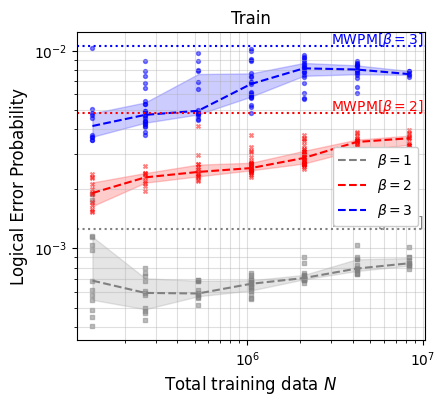

In [132]:
fig1, train_ax = plt.subplots(1, 1, figsize=(4.5, 4))

for i in range(len(nsweep_betas)):
    # plot train accuracies
    for suby in ys_tr[i]:
        train_ax.scatter(suby[0], suby[1], color=colors[i], alpha=0.5, s=8, marker=markers[i])
    train_ax.plot(n_train_vals, ystats_tr[i][:,0], color=colors[i], ls='--', label=r"$\beta=$"+f"{nsweep_betas[i]}")
    train_ax.fill_between(n_train_vals, ystats_tr[i][:,0] - ystats_tr[i][:,1], ystats_tr[i][:,0]+ ystats_tr[i][:,2], color=colors[i], alpha=0.2)

# MWPM annotations
for i, err in enumerate(mwpm_errs):
    train_ax.axhline(err, ls=':', color=colors[i])
    train_ax.text(3e6, err * 1.03, "MWPM[" + r"$\beta=$" + f"{i+1}]", color=colors[i] )


# axes[1].set_title("Validation")
train_ax.set_title("Train")
train_ax.loglog()
train_ax.grid(which='both', alpha=0.4)
train_ax.set_xlabel(r"Total training data $N$", size=12)
train_ax.set_ylabel("Logical Error Probability", size=12)
# ax.text(0.5, 0.5, "FIXME: REGENERATE", transform=axes[1].transAxes, size=14, color="purple")
train_ax.legend(framealpha=1)
fig1.savefig(f"../../figures/gnn_results_train.pdf", bbox_inches='tight')

Same plots but for nontrivial training data

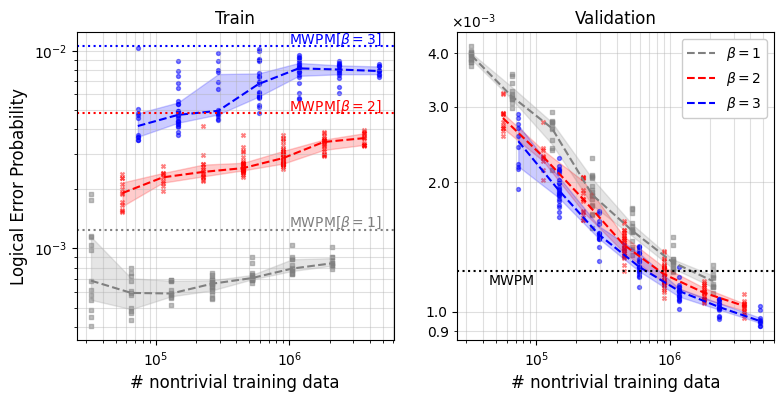

In [40]:

target_df = df_v03
n_train_vals = np.array(list(sorted(target_df["n_train"].unique())))
betas = [1, 2, 3]
frac_nontrivial = [0.25, 0.43, 0.56]
ys_val = []
ystats_val = []
ys_tr = []
ystats_tr = []
for discount, beta in zip(frac_nontrivial, betas):
    ys_tr.append(make_yvals_v2(target_df, n_train_vals , beta, target_col='train_acc')) # raw outcomes
    ystats_tr.append(make_yvals_v1(target_df, n_train_vals , beta, target_col='train_acc')) # statistical stuff
    ys_val.append(make_yvals_v2(target_df, n_train_vals , beta, target_col='val_acc')) # raw outcomes
    ystats_val.append(make_yvals_v1(target_df, n_train_vals , beta, target_col='val_acc')) # statistical stuff
colors = ['grey', 'red', 'blue']
markers = ['s', 'x', 'o']


fig, axes = plt.subplots(1, 2, figsize=(9, 4))
for i in range(len(betas)):
    discount = frac_nontrivial[i]
    # plot validation accuracies
    for suby in ys_tr[i]:
        axes[0].scatter(suby[0]* discount, suby[1], color=colors[i], alpha=0.5, s=8, marker=markers[i])
    axes[0].plot(n_train_vals * discount, ystats_tr[i][:,0], color=colors[i], ls='--', label=r"$\beta=$"+f"{betas[i]}")
    axes[0].fill_between(n_train_vals * discount, ystats_tr[i][:,0] - ystats_tr[i][:,1], ystats_tr[i][:,0]+ ystats_tr[i][:,2], color=colors[i], alpha=0.2)

    # plot train accuracies
    for suby in ys_val[i]:
        axes[1].scatter(suby[0]* discount, suby[1], color=colors[i], alpha=0.5, s=8, marker=markers[i])
    axes[1].plot(n_train_vals * discount, ystats_val[i][:,0], color=colors[i], ls='--', label=r"$\beta=$"+f"{betas[i]}")
    axes[1].fill_between(n_train_vals * discount, ystats_val[i][:,0] - ystats_val[i][:,1], ystats_val[i][:,0]+ ystats_val[i][:,2], color=colors[i], alpha=0.2)

for i, err in enumerate(mwpm_errs):
    axes[0].axhline(err, ls=':', color=colors[i])
    axes[0].text(1e6, err * 1.03, "MWPM[" + r"$\beta=$" + f"{i+1}]", color=colors[i] )

axes[1].axhline(mwpm_errs[0], ls=':', c='k')
axes[1].text(0.1, 0.18, "MWPM", transform=axes[1].transAxes)

axes[1].set_title("Validation")
axes[0].set_title("Train")
for ax in axes:
    ax.loglog()
    ax.grid(which='both', alpha=0.4)
    ax.set_xlabel(r"# nontrivial training data", size=12)
    # ax.text(0.5, 0.5, "FIXME: REGENERATE", transform=axes[1].transAxes, size=14, color="purple")
axes[1].legend(framealpha=1)
axes[0].set_ylabel("Logical Error Probability", size=12)

# prettier sci not
formatter = CustomFormatter(useMathText=True)
for axis in [axes[1]]:
    axis.yaxis.set_major_formatter(formatter)
    axis.yaxis.set_minor_formatter(formatter)
    axis.yaxis.offsetText.set_visible(True)
    axis.yaxis.get_offset_text().set_position((-0.02, 0))  # Adjust position as needed
    axis.yaxis.get_offset_text().set_size(10)

fig.savefig(f"../../figures/gnn_nontrivial_comparison.pdf", bbox_inches='tight')


In [38]:
# mwpm_err = 8e-4 # p=0.001
# mwpm_err = 0.0113 # p=0.004
# mwpm_err = 1 - .99881 #current problem
plt.close('all')
def plot_by_variables(df, col_name):
    """Plot the validation error vs train error in different colors for each unique value of col_name."""
    colors = plt.cm.rainbow(np.linspace(0, 1, len(df[col_name].unique())))
    fig, ax = plt.subplots(figsize=(5, 5))
    for col_val, color in zip(df[col_name].unique(), colors):
        half = df[df[col_name] == col_val]
        x = 1- half["train_acc"]
        y = 1 - half["val_acc"]
        ax.scatter(x, y, alpha=0.5, label=f"{col_name}={col_val}")
        ax.set_xlabel("Train error")
        ax.set_ylabel("Validation error")
        # plot training error for beta=1 and 2
        ax.axhline(mwpm_err_beta1, ls='--', c='r')
        ax.axvline(mwpm_err_beta1, ls='--', c='r')
        ax.axvline(mwpm_err_beta2, ls='--', c='g')
        ax.axvline(mwpm_err_beta3, ls='--', c='b')
        ax.loglog()
        ax.legend(bbox_to_anchor=(1, 1), loc="upper left")


# plot_by_variables(df, 'batch_size')
# plot_by_variables(df, 'gcn_depth')
# plot_by_variables(df, 'lr')
# plot_by_variables(df, 'gcn_min')
# plot_by_variables(df, 'mlp_depth')


In [40]:
# Function to create bins with roughly equal number of samples
def create_equal_sized_bins(data, n_bins):
    """
    Create bins with roughly equal number of samples.
    
    Args:
        data: Series of values to bin
        n_bins: Number of bins to create
    
    Returns:
        bins: List of bin edges
        labels: List of bin labels
    """
    # Remove NaN values for quantile calculation
    valid_data = data.dropna()
    
    # Calculate quantiles for equal-sized bins
    quantiles = np.linspace(0, 1, n_bins + 1)
    bins = np.quantile(valid_data, quantiles)
    
    # Ensure unique bin edges (can happen with discrete data)
    bins = np.unique(bins)
    
    # Create labels for the bins (using the format "min-max")
    labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]
    
    return bins, labels

target_df = df_v03
# Bin time_elapsed into 10 roughly equal sized bins
time_bins, time_labels = create_equal_sized_bins(target_df['time_elapsed'], 10)
target_df['time_elapsed_bin'] = pd.cut(target_df['time_elapsed'], bins=time_bins, labels=time_labels)

# Bin param_count into 5 roughly equal sized bins
param_bins, param_labels = create_equal_sized_bins(target_df['param_count'], 5)
target_df['param_count_bin'] = pd.cut(target_df['param_count'], bins=param_bins, labels=param_labels)

epoch_bins, epoch_labels = create_equal_sized_bins(target_df['epoch'], 5)
target_df['epoch_bin'] = pd.cut(target_df['epoch'], bins=epoch_bins, labels=epoch_labels)


# # Display the distribution of samples in each bin
# print("Time elapsed bins distribution:")
# print(df_v02['time_elapsed_bin'].value_counts().sort_index())
# print("\nParameter count bins distribution:")
# print(df_v02['param_count_bin'].value_counts().sort_index())


In [ ]:
plt.close('all')
for col in ["epoch_bin", "beta", "lr","batch_size"	,"gcn_depth",	
            "gcn_min",	"mlp_depth",	"mlp_max",	
            "n_train", "time_elapsed_bin", "param_count_bin", ]:
    plot_by_variables(target_df, col)

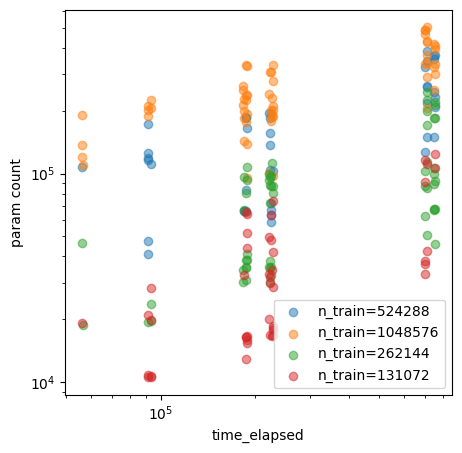

In [38]:
# Here we will plot the timing and parameter count for each run versus the choice of hyperparameters
def plot_by_variables_timing(df, col_name):
    """Plot the validation error vs train error in different colors for each unique value of col_name."""
    colors = plt.cm.rainbow(np.linspace(0, 1, len(df[col_name].unique())))
    fig, ax = plt.subplots(figsize=(5, 5))
    for col_val, color in zip(df[col_name].unique(), colors):
        half = df[df[col_name] == col_val]
        x = half["param_count"]
        y = half["time_elapsed"]
        ax.scatter(x, y, alpha=0.5, label=f"{col_name}={col_val}")
        ax.set_xlabel("time_elapsed")
        ax.set_ylabel("param count")
        ax.loglog()
        ax.legend()

for col in ["n_train"]:
# for col in ["beta", "lr","batch_size"	,"gcn_depth",	
#             "gcn_min",	"mlp_depth",	"mlp_max",	
#             "n_train", "time_elapsed_bin", "param_count_bin", ]:
    plot_by_variables_timing(df_v02, col)

array([[<Axes: title={'center': 'epoch'}>]], dtype=object)

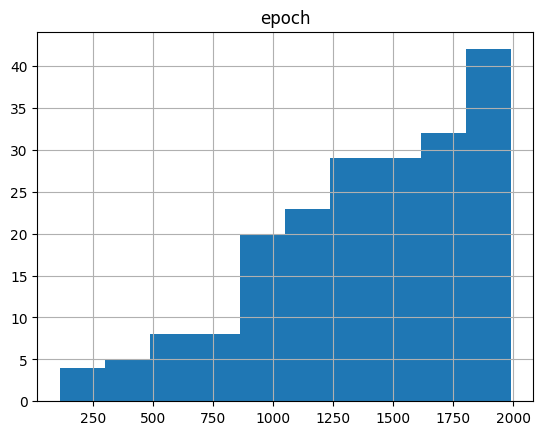

In [31]:
# df_v02.hist("total_epochs")
# unfortunately we didn't have enough epochs for a lot of these runs...
df_v02.hist("epoch")

### What do we see?
 - depth 6 and 7 models are really slow
 - there are a bunch of param counts > 700,000 and these consume a shitload of time.
 - beta=2 is doing visibly better in validation.
 - parameter count has a lot more effect than training data ccount! This is promising, I can do the training sweep. The problem is that my minimum runtime was 27 hours, typical was 2*10^5 i.e. 50 hours....
 - gcn_min 32 seems not appreciably worse than 64, so we could potentially cut out that. I think this is justified since I'm studying relative performance anyways. 
 - batch size doesn't really influence much, lets go with 1024
 - we ran out of epochs for a good chunk of runs :(

Decisions:
 - remove mlp_max=256
 - remove depth=7, add depth=4
 - add 2 million, 4 million training data
 - remove 512 batch size
 - remove lr=0.0001, add lr=0.0004
 - keep gcn_min 32 and 64; i would like to argue that "bigger beta is worth more than hyperparameter tuning"
 - add beta=3, and another 100 experiments
 - increase epochs from 2000 to 3000


array([[<Axes: title={'center': 'vs_minweight'}>]], dtype=object)

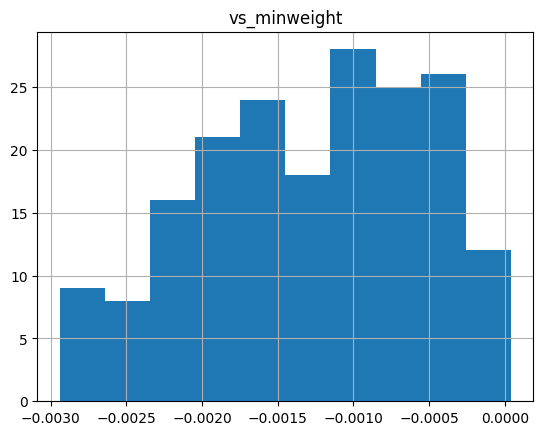

In [16]:
df.hist("vs_minweight")

#### Recovery script